<a href="https://colab.research.google.com/github/AlvearVanessa/TFM/blob/main/Modelo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo final de máster: Predicción de la edad a partir del estado de la retina mediante técnicas de aprendizaje profundo
---


#Introducción
---

Este es el Notebook 5. El objetivo es crear el primer modelo de regresión en imágenes utilizando técnicas de Aprendizaje profundo.

Para este caso, se utiliza la arquitectura ResNet50



#Autora
---

Este trabajo es realizado por:

- Mayra Vanessa Alvear Gallón

#Objetivo
---


El problema que se quiere resolver es de regresión, esto es, a partir de una imágen que contiene el rostro de una persona, se quiere predecir su edad mediante la implementación del modelo ReNet50.


## Librerías
---


Para iniciar, se descarga la última versión de la librería FastAI. Al finalizar la instalación, se debe reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [ ]:
!pip install fastai -Uq

     |████████████████████████████████| 197 kB 5.3 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 


Se cargan aquellas librerías que son necesarias.

In [ ]:
# models and depp learning library
from fastai.vision.all import *

# preprocessing and data management
import scipy.io
import pandas as pd
from datetime import datetime, timedelta

#Split dataset
from sklearn.model_selection import train_test_split

# model evaluation
from fastai.metrics import mae

## Análisis de datos
---

Se va a utilizar el conjunto de datos obtenido como resultado del preprocesado realizado en el notebook 1.

### Dataset
---

**El conjunto de datos**

Contiene imágenes de fondo de ojo con etiquetas de edad para entrenamiento. Estas imágenes son de tamaño 299x299, algunas son del ojo izquierdo y otras del ojo derecho, esto se puede visualizar a partir de la ubicación de la mácula

Dado que los archivos se encuentra en una carpeta de Google Drive, se carga para acceder a los archivos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se explora el contenido de este conjunto de datos. Para ello, se crea un objeto [Path](https://docs.python.org/3/library/pathlib.html) que apunta al directorio que acabamos de crear. 

In [ ]:
path = Path('/content/drive/MyDrive/dataset_retina/')

In [ ]:
pathDataframes = Path('/content/drive/MyDrive/dataset_retina/dataframes')

In [ ]:
pathDatasets = Path('/content/drive/MyDrive/dataset_retina/datasets')

Con el objeto path se pueden utilizar funciones como `ls()`.

In [ ]:
path.ls()

(#9) [Path('/content/drive/MyDrive/dataset_retina/dataframes.zip'),Path('/content/drive/MyDrive/dataset_retina/original_test.zip'),Path('/content/drive/MyDrive/dataset_retina/original_train.zip'),Path('/content/drive/MyDrive/dataset_retina/nuevo_testing.zip'),Path('/content/drive/MyDrive/dataset_retina/nuevo_training.zip'),Path('/content/drive/MyDrive/dataset_retina/dataframes.zip (Unzipped Files)'),Path('/content/drive/MyDrive/dataset_retina/dataframes'),Path('/content/drive/MyDrive/dataset_retina/datasets'),Path('/content/drive/MyDrive/dataset_retina/notebooks')]

In [ ]:
trainPath = pathDatasets/'train'
testPath = pathDatasets/'test'

In [ ]:
trainPath.ls()

(#34991) [Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_9740.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_1000305.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_978980.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_1001345.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_1001957.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_1002097.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_1005146.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_100760.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_10189.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_training/anonymized_102768.jpg')...]

In [ ]:
testPath.ls()

(#8748) [Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_795734.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_796326.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_797216.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_797382.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_79743.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_799441.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_800204.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_801406.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_802443.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/nuevo_testing/anonymized_803215.jpg')...]

Se cargan los dataframes dfTrain y dfTest

In [ ]:
dfTrain = pd.read_csv(pathDataframes/'train.csv')
dfTest = pd.read_csv(pathDataframes/'test.csv')

In [ ]:
dfTrain.shape

(34991, 2)

In [ ]:
dfTest.shape

(8748, 2)

In [ ]:
df = pd.concat([dfTrain, dfTest]) #El orden de concatenación es importante: Los de train están arriba y test abajo

In [ ]:
df.head(10)

,nombre_foto,edad
0,anonymized_1291978.jpg,72
1,anonymized_760487.jpg,60
2,anonymized_793931.jpg,52
3,anonymized_242202.jpg,54
4,anonymized_371254.jpg,67
5,anonymized_985803.jpg,74
6,anonymized_426787.jpg,40
7,anonymized_379994.jpg,38
8,anonymized_459098.jpg,37
9,anonymized_397860.jpg,54


La dimensión del df

In [ ]:
df.shape

(43739, 2)

El dataframe contiene 43739 filas y 2 columnas

## Cargando el dataset
---

Se carga el dataset para poder posteriormente crear el modelo. Este proceso se hace en dos pasos. Primero se construye un objeto `DataBlock` y a continuación se construye un objeto `DataLoader` a partir del `DataBlock`.


Se hace un get_x y un get_y usando el dataframe

In [ ]:
get_x = ColReader('nombre_foto', pref= trainPath)
get_y = ColReader('edad')

### Datablock
---

El Datablock es un contenedor genérico para crear rápidamente Datasets y DataLoaders. Se construye el objeto `block` de la clase `DataBlock`. 

Dado que se tienen un conjunto de entrenamiento y uno de test, se toma de forma aleatorea el conjunto de validación a partir de nuestro conjunto de entrenamiento usando un 15% del mismo. Además, se aplica una técnica de preescalado (presizing) y una técnica de aumento de datos (o data augmentation).

In [ ]:
#RegressionBlock: Bloque de transformación para variables objetivos flotantes
block = DataBlock(blocks=(ImageBlock, RegressionBlock()), #Recibe imágenes y devuelve un RegressionBlock, los valores numéricos 
                  get_x = get_x, 
                  get_y = get_y, 
                  splitter=RandomSplitter(valid_pct=0.15, seed=42), #El 15% de los datos de Training son para validar
                  item_tfms=Resize(299), #Cómo determinar el resize si las imágenes tienen diferente tamaño https://docs.fast.ai/vision.augment.html#Resize-with-crop,-pad-or-squish
                  batch_tfms=[*aug_transforms(size=224, flip_vert = True)])

Se puede hacer resize con: crop, squish pad

Padding: Todos los modos de relleno posibles como atributos para completar pestañas y corregir errores tipográficos.

CropPad: Centro de recorte o almohadilla en la imagen para ajustar el tamaño.

Squish: aplastamos cualquier rectángulo a medida. Squish se usa en el conjunto de validación, eliminando primero la proporción val_xtra de cada lado.

https://docs.fast.ai/vision.augment.html#Resize-with-crop,-pad-or-squish

Aug aumentation y una deformación de perspectiva de max_warp. Como es igual a 0, no hay deformación. Su valor por defecto es 0.2

https://docs.fast.ai/vision.augment.html#aug_transforms

### Dataloaders
---

Ahora, se construye el `DataLoader` a partir del `DataBlock` construido anteriormente indicándole el path donde se encuentran las imágenes. 

El método dataloaders de la clase DataBlock, utiliza por defecto un bath size de 64 imágenes.

In [ ]:
dls = block.dataloaders(dfTrain) #bs = 64 por defecto

A continuación se muestra un batch del `DataLoader`. Es conveniente comprobar que realmente se han cargado las imágenes y sus anotaciones de manera correcta.

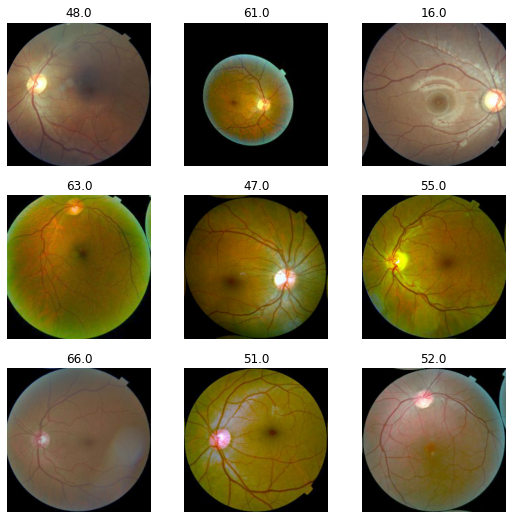

In [ ]:
dls.show_batch()

In [ ]:
#Intento
dls.valid.show_batch(max_n=4, nrows=1)

#Entrenando el modelo
---

# Modelo 4: ResNet 50
---

Se crea un modelo usando la arquitectura resnet50

Por consiguiente, se puede construir y entrenar el modelo. Pero antes se define una serie de *callbacks*.

Se utilizan 3 callbacks:

- ShowGraphCallback. 
- EarlyStoppingCallback. 
- SaveModelCallback. 

Con esto se quiere:

- Mostrar las curvas de entrenamiento y validación. 
- Aplicar la técnica de early stopping. 
- Guardar el mejor modelo encontrado durante el proceso de entrenamiento y lo carga al final del mismo.

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3), #Patiente depende del nhttps://docs.fast.ai/vision.augment.html#Resize-with-crop,-pad-or-squishúmero de épocas
    SaveModelCallback(fname='modelResnet50')  
]

#Construyendo el modelo
---

Se construye el modelo por medio de un objeto de la clase `Learner`, se utiliza el método `cnn_learner` que toma como parámetros el `DataLoader`, la arquitectura que se quiere entrenar (para este caso `resnet50`), la métrica que se usa para evaluar el modelo (esta evaluación se hace sobre el conjunto de validación, y en en este caso será la *mae*), y los callbacks. Notar que en la instrucción anterior se incluye la transformación del modelo a *mixed precision* mediante la instrucción ``to_fp16``.

Se construye el Learner

In [ ]:
learn = cnn_learner(dls, resnet50, loss_func=MSELossFlat(), y_range=(0,100), metrics=mae, cbs=callbacks ).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### Learning rate finder
---
Se emplea el método para encontrar un learning rate adecuado para entrenar nuestro modelo. Dicho learning rate se puede encontrar con la función `lr_find()`.

SuggestedLRs(valley=0.00019054606673307717)

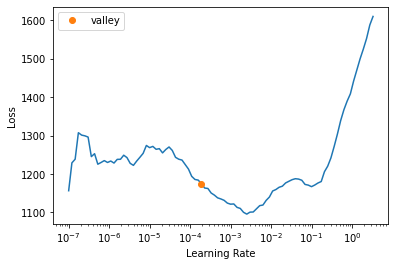

In [ ]:
learn.lr_find()

### Fine-tuning
---

Se aplica la técnica de *fine tuning*. En FastAI esto es tan sencillo como llamar al método `fine_tune` del objeto `Learner`. Este método recibe dos parámetros principalmente, el número de épocas (10 en nuestro caso) y el learning rate. El proceso que sigue para entrenar consiste en:
1. Congelar todas las capas salvo la última, y entrenar esa parte del modelo durante una época.
2. Descongelar la red, y entrenar el modelo por el número de épocas indicado. 

Veremos una tabla donde podrás ver la pérdida para el conjunto de entrenamiento, la pérdida para el conjunto de validación, y el mae para el conjunto de validación. 

epoch,train_loss,valid_loss,mae,time
0,804.341309,436.785095,17.392441,1:00:20


Better model found at epoch 0 with valid_loss value: 436.78509521484375.


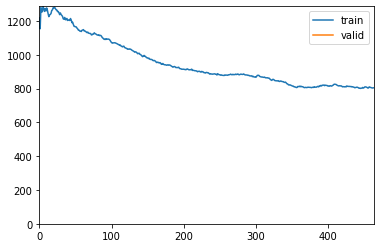

epoch,train_loss,valid_loss,mae,time
0,733.314087,365.222473,15.773872,11:56
1,666.381226,316.159790,14.605776,11:51
2,559.404297,250.278290,12.602639,11:52
3,365.780487,152.798477,9.458565,11:58
4,221.504822,119.702812,8.360745,11:59
5,172.015427,100.225647,7.569069,11:56
6,150.312500,93.984329,7.310439,11:57
7,139.838593,91.253807,7.204015,11:56
8,128.103500,90.283615,7.175463,11:57
9,130.906143,89.472427,7.126339,11:56


Better model found at epoch 0 with valid_loss value: 365.22247314453125.


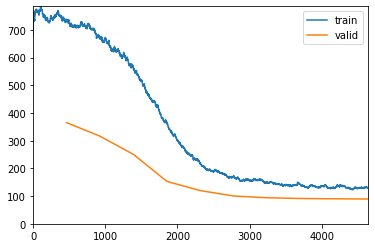

Better model found at epoch 1 with valid_loss value: 316.1597900390625.
Better model found at epoch 2 with valid_loss value: 250.27828979492188.
Better model found at epoch 3 with valid_loss value: 152.79847717285156.
Better model found at epoch 4 with valid_loss value: 119.70281219482422.
Better model found at epoch 5 with valid_loss value: 100.22564697265625.
Better model found at epoch 6 with valid_loss value: 93.98432922363281.
Better model found at epoch 7 with valid_loss value: 91.2538070678711.
Better model found at epoch 8 with valid_loss value: 90.28361511230469.
Better model found at epoch 9 with valid_loss value: 89.47242736816406.


In [ ]:
learn.fine_tune(10, 1e-4)

Al final del entrenamiento se ha guardado un modelo en la carpeta `models` que contiene el mejor modelo construido.

In [ ]:
Path('models').ls()

(#1) [Path('models/modelResnet50.pth')]

Para su uso posterior, es conveniente exportar el modelo. Para ello es necesario en primer lugar convertir el modelo a fp32.

In [ ]:
learn.to_fp32()
learn.export()

Se puede ver que dicho modelo se ha guardado en el mismo directorio donde nos encontramos. 

In [ ]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

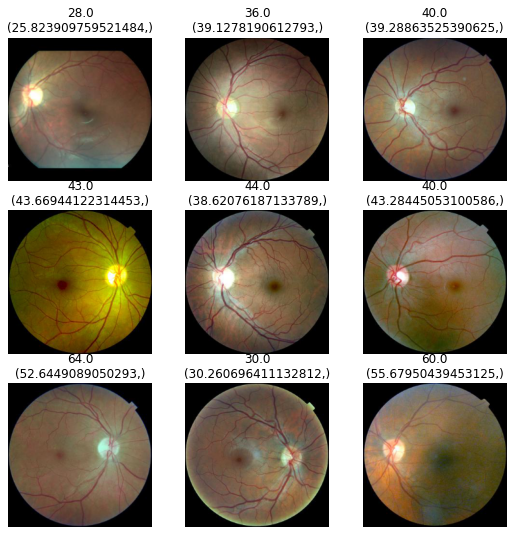

In [ ]:
learn.show_results()

# Evaluando el modelo en el conjunto de test
---

Para poder evaluar el modelo en el conjunto de test debemos crear un nuevo `DataBlock` y un nuevo `DataLoader`. La única diferencia con el `DataBlock` utilizado previamente es que para hacer la partición del dataset usamos un objeto de la clase `IndexSplitter` para indicar el conjunto de test. En el caso del `DataLoader`, cambiamos la ruta al path. 

In [ ]:
df1 = pd.concat([dfTrain, dfTest]) #El orden de concatenación es importante: Los de train están arriba y test abajo

In [ ]:
df1.shape

(43739, 2)

Dado que, el conjunto de test se ha creado a partir de un subconjunto del dataset, entonces para considerarlo en la evaluación del modelo, usamos la clase ``IndexSplitter``.

Para ello, se ha creado el dataframe *df1*, construido a partir de la concatenación del dfTrain y dfTest (en este orden). Luego, se seleccionan sólo los elementos de test de df1 teniendo en cuenta las longitudes de dfTrain y de df1. De esta manera, esta clase divide los elementos de dfTest en el conjunto de validación y los demás en el conjunto de entrenamiento.

In [ ]:
allPath = pathDatasets/'all_images'

In [ ]:
allPath.ls()

(#43739) [Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_9740.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_1000305.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_978980.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_1001345.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_1001957.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_1002097.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_1005146.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_100760.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_10189.jpg'),Path('/content/drive/MyDrive/dataset_retina/datasets/all_images/anonymized_102768.jpg')...]

In [ ]:
get_x = ColReader('nombre_foto', pref= allPath)
get_y = ColReader('edad')

In [ ]:
#RegressionBlock: Bloque de transformación para variables objetivos flotantes
dbTest = DataBlock(blocks=(ImageBlock, RegressionBlock()), #Recibe imágenes y devuelve un RegressionBlock
                  get_x = get_x, 
                  get_y = get_y, 
                  splitter= IndexSplitter(range(len(dfTrain) + 1, len(df1))),  #Para carpetas GrandparentSplitter(valid_name='dfTest').l 15% de los datos de Training son para validar
                  #splitter=GrandparentSplitter(valid_name='test'), #Usamos el conjunto de test
                  item_tfms = Resize(299), 
                  batch_tfms=[*aug_transforms(size=224, flip_vert = True)])

In [ ]:
dlsTest = dbTest.dataloaders(df1, bs=150)

Para trabajar con este dataloader se debe modificar el objeto `Learner`. En concreto su atributo `dls`. 

In [ ]:
learn.dls = dlsTest

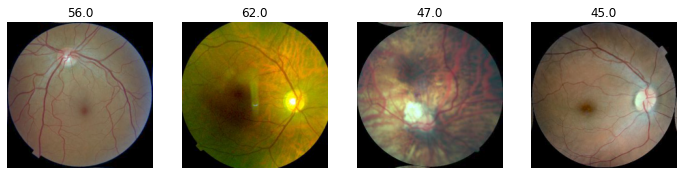

In [ ]:
dlsTest.show_batch(max_n=4, nrows=1)

Por último, se evalúa el modelo usando el método `validate`.

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 16.6423282623291.


(#2) [391.5623474121094,16.6423282623291]

El método `validate` devuelve dos valores: el valor de la función de pérdida, y el valor de nuestra métrica (mae en este caso). Por lo que se puede ver que el modelo tiene un mae en el conjunto de test de aproximadamente un 16.64% (esto puede variar dependiendo de la ejecución) para 10 épocas.


Además, se pueden visualizar las predicciones obtenidas sobre algunas imágenes del conjunto de test, donde, el número de arriba es el Ground Truth y el de abajo es la edad obtenida de la predicción

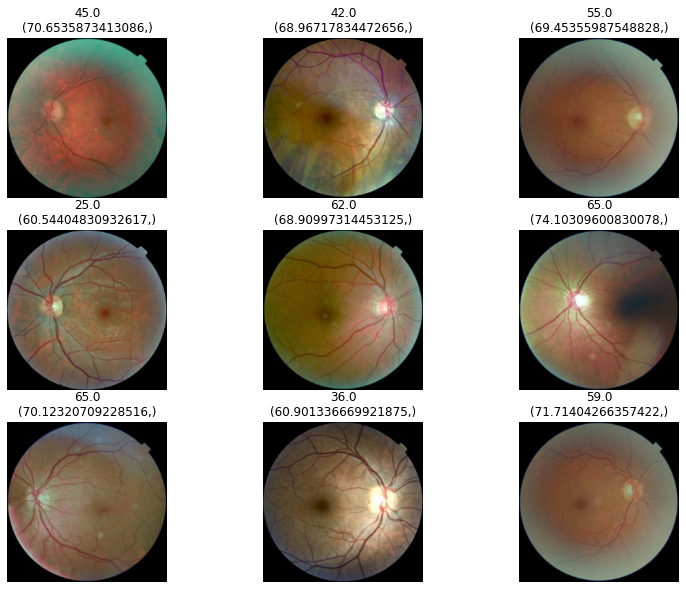

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(13,10))

Se intentará mejorar esta métrica con otros modelos.

# Usando el modelo
---

Se puede ver cómo usar el modelo ante una nueva imagen. Para ello lo primero que se va a hacer es cargar dicho modelo. 

In [ ]:
learn_inf = load_learner('export.pkl')

Se carga la imagen del conjunto de test y se predice la edad sobre la persona de la misma

In [ ]:
dfTest.head(8)

,nombre_foto,edad
0,anonymized_341764.jpg,51
1,anonymized_698952.jpg,69
2,anonymized_208387.jpg,46
3,anonymized_118817.jpg,69
4,anonymized_1311174.jpg,32
5,anonymized_1326804.jpg,32
6,anonymized_108292.jpg,48
7,anonymized_37285.jpg,61


Se elige una de las imágenes

In [ ]:
img = '/content/anonymized_341764.jpg'

In [ ]:
learn_inf.predict(img)

((44.80289077758789), TensorBase([44.8029]), TensorBase([44.8029]))

La función anterior devuelve que el valor de la regresión obtenido (la edad en este caso) es de 44 años para la persona de la imagen del conjunto de Test. Sin embargo, la edad real es 51 años.